In [4]:
!pip install optuna
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install scikit-optimize
!pip install opencv-python



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 34.1 MB/s eta 0:00:00a 0:00:01


In [5]:
#CONSTANTS

import os
# from google.colab import drive; drive.mount('/content/drive') #colab
# datasetPath = 'drive/MyDrive/dataset/' # google colab
datasetPath = 'dataset/' # local


ROI_THRESHOLD = 100
# INPUT_SHAPE = (354,386, 3) avg for dataset
INPUT_SHAPE = (224, 224, 3) # imagenet
# (386, 354)

#DATA AUGMENTATION
BRIGHTNESS_RANGE = [0.8, 1.2]
WIDTH_SHIFT_RANGE=0.2  # Random horizontal shift
HEIGHT_SHIFT_RANGE=0.2

#K - FOLD
N_SPLITS = 5

#TRAINING
BATCH_SIZE = 32
EPOCHS = 5

TEST_SPLIT = 0.1
VALIDATION_SPLIT = 0.1

Number Of Yes Samples:  149
Number Of No Samples:  73


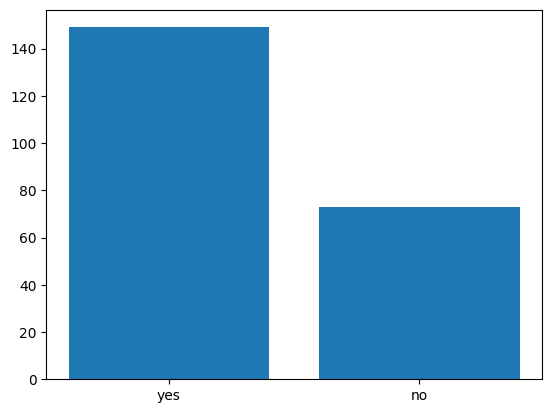

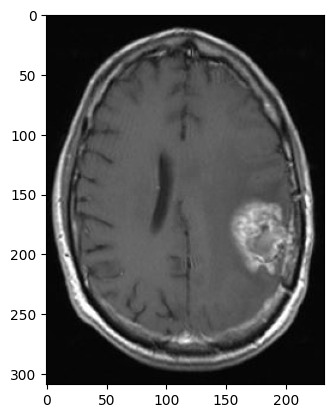

In [6]:
# import the images
import os
import cv2
def open_image(path):
    img = cv2.imread(path)
    if img is None:  # Check if loading failed
        print(f"❌ Failed to load: {path}")
    return img
valid_extensions = (".jpg", ".jpeg",".JPG",".JPEG" ".png")  # Add more if needed, its to remove .DS_Store

# open all valid images in the yes directory
yes_dir = datasetPath+"yes"
yes = [open_image(os.path.join(yes_dir, f)) for f in os.listdir(yes_dir) if f.lower().endswith(valid_extensions)] 

no_dir=datasetPath+'no'
no = [open_image(os.path.join(no_dir, f)) for f in os.listdir(no_dir)]

print("Number Of Yes Samples: ", len(yes))
print("Number Of No Samples: ", len(no))

# visulise the ratio of yes to no
import matplotlib.pyplot as plt
plt.bar(["yes", "no"], [len(yes), len(no)])
plt.show()

plt.imshow(yes[0])
plt.show()

Length Of Training Set : 142
Length Of Validation Set : 21


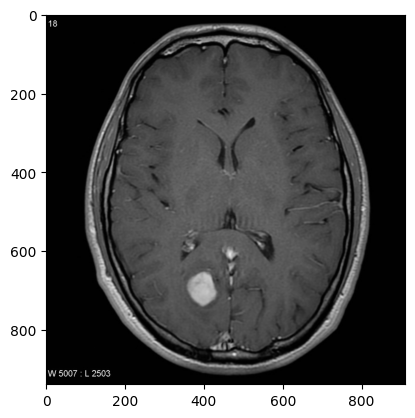

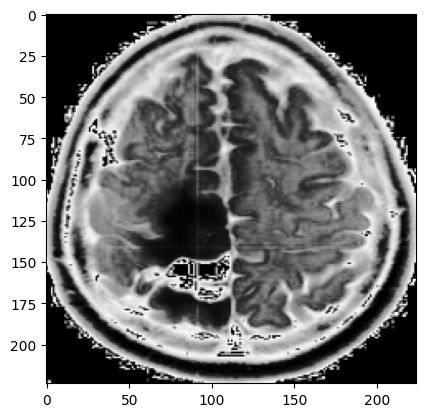

In [8]:
# apply the preprocessing to the images


#ROI Extraction
import numpy as np


def crop(img, threshold_value=0.2):
    """
    Crops the region of interest (ROI) by removing unnecessary black areas.

    :param img: Grayscale image (1-channel, values in [0, 255])
    :param threshold_value: Threshold for binary conversion (range [0, 1])
    :return: Cropped image (if ROI is found), otherwise None
    """
    # Ensure image is uint8
    img = (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)

    # Apply binary threshold
    _, threshold = cv2.threshold(img, threshold_value * 255, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Get bounding box of the largest contour (to ensure capturing full ROI)
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        cropped = img[y:y+h, x:x+w]
        #print(f"Cropped image dimensions: {cropped.shape}")
        return cropped
    else:
        print("No ROI detected.")
        return None  # Return None if no valid ROI is found
# normalise the images
def normalise(img):
    """
    :param img: The image to be normalised (in BGR format, pixels in range [0, 255])
    """
    # Normalize the image to the range [0, 1]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #cvt to grayscale
    return img / 255.0

#def function to preprocess the image
def preprocess(img):
    """Apply cropping, grayscale conversion, normalization, and histogram equalization."""

    # print(img.shape)
    img = normalise(img)  # Convert to grayscale and normalize to [0,1]
    img = crop(img)  # Crop unnecessary black areas

    # Convert back to uint8 (0-255) for histogram equalization
    img_uint8 = (img * 255).astype(np.uint8)

    # Apply histogram equalization
    equalized_img = cv2.equalizeHist(img_uint8)

    # Convert back to normalized float format [0,1]
    eq =equalized_img.astype(np.float32) / 255.0

    #resize to (386.0810810810811,354.27927927927925) avg for dataset
    eq = cv2.resize(eq, [INPUT_SHAPE[0],INPUT_SHAPE[1]])
    # print('working')
    # Convert grayscale to RGB by repeating the gray values across 3 channels
    rgb_image = cv2.cvtColor(eq, cv2.COLOR_GRAY2RGB)


    return rgb_image

# preprocess the images
import math
processed_yes = [preprocess(img) for img in yes]
processed_no = [preprocess(img) for img in no]

# remove the validation data
numYes = math.trunc(len(processed_yes)*TEST_SPLIT)
numNo = math.trunc(len(processed_no)*TEST_SPLIT)

validation_yes = processed_yes[:numYes]
validation_no = processed_no[:numNo]
processed_yes = processed_yes[numYes:]
processed_no = processed_no[numNo:]

print("Length Of Training Set :", len(processed_yes) + len(validation_no))
print("Length Of Validation Set :", len(validation_yes)+len(validation_no))
plt.imshow(yes[1], cmap='gray')
plt.show()
plt.imshow(processed_yes[1], cmap='gray')
plt.show()





In [9]:
# Augmentation, create_model and something function definition
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import numpy as np
from tensorflow.keras.preprocessing import image
from tqdm import tqdm  # Progress bar to track augmentation
import tensorflow as tf

from tensorflow.keras.applications import InceptionV3,ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.model_selection import StratifiedKFold
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, VGG19, MobileNet, DenseNet121, EfficientNetB0, Xception, InceptionV3
from tensorflow.keras.optimizers import Adam, SGD

def augmentation2a(images, labels, batch_size=32, target_size=INPUT_SHAPE):
    """
    Augment the images while ensuring that both classes (0 and 1) have the same number of images.
    
    Args:
    - images: numpy array of images (shape: [n_samples, height, width, channels])
    - labels: numpy array of labels corresponding to the images
    - batch_size: number of samples per batch (default: 32)
    - target_size: the target size for images (default: INPUT_SHAPE)
    
    Returns:
    - balanced_images: numpy array of augmented images (balanced)
    - balanced_labels: numpy array of corresponding labels
    """
    
    from collections import Counter
    
    # Count class distribution
    label_counts = Counter(labels)
    max_class_size = max(label_counts.values())  # Largest class size
    print(f"Original class distribution: {label_counts}")

    # Initialize ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=BRIGHTNESS_RANGE,
    )

    balanced_images = []
    balanced_labels = []
    
    for class_label in np.unique(labels):
        # Select images of the current class
        class_images = images[labels == class_label]
        num_needed = max_class_size - len(class_images)
        
        # If already balanced, just add original images
        balanced_images.append(class_images)
        balanced_labels.append(np.full(len(class_images), class_label))
        
        if num_needed > 0:  # Apply more augmentations if needed
            print(f"Generating {num_needed} extra images for class {class_label}...")
            aug_images = []
            aug_labels = []
            
            for x_batch, _ in datagen.flow(class_images, np.full(len(class_images), class_label), 
                                           batch_size=batch_size, shuffle=True):
                aug_images.append(x_batch)
                aug_labels.append(np.full(len(x_batch), class_label))
                
                if len(aug_images) * batch_size >= num_needed:
                    break
            
            # Convert to numpy and trim excess
            aug_images = np.concatenate(aug_images, axis=0)[:num_needed]
            aug_labels = np.concatenate(aug_labels, axis=0)[:num_needed]
            
            balanced_images.append(aug_images)
            balanced_labels.append(aug_labels)
    
    # Convert to numpy arrays
    balanced_images = np.concatenate(balanced_images, axis=0)
    balanced_labels = np.concatenate(balanced_labels, axis=0)
    
    print(f"Balanced dataset created: {Counter(balanced_labels)}")
    
    return balanced_images, balanced_labels

#create model function


def create_model(model_type, learning_rate=0.001, optimizer='adam', neurons_in_dense_layer=512, dropout_rate=0.5,**kwargs):
    """
    Create a model based on the specified type.
    Args:
    - model_type: string indicating the type of model to create
    - learning_rate: learning rate for the optimizer (default: 0.001)
    - optimizer: optimizer to use (default: 'adam')
    - neurons_in_dense_layer: number of neurons in the dense layer (default: 512)
    - dropout_rate: dropout rate for dropout layer (default: 0.5)
    - **kwargs: additional keyword arguments

    Returns:
    - (model,base_model,top) : the model is the full model, 
                                base_model is the pre-trained model,
                                top is the task specific model
    """
    print("creating model model type: ",model_type, " optimizer: ",optimizer, " neurons in dense layer: ",neurons_in_dense_layer, " dropout rate: ",dropout_rate)
    # print(model_type)
    if model_type == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
        base_model.trainable = False  # Freeze layers
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(neurons_in_dense_layer, activation='relu'),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])

    elif model_type == 'vgg19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
        base_model.trainable = False
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(neurons_in_dense_layer, activation='relu'),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])

    elif model_type == 'mobilenet':
        base_model = MobileNet(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
        base_model.trainable = False
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(neurons_in_dense_layer, activation='relu'),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])

    elif model_type == 'densenet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
        base_model.trainable = False
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(neurons_in_dense_layer, activation='relu'),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])

    elif model_type == 'efficientnet':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
        base_model.trainable = False
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(neurons_in_dense_layer, activation='relu'),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])

    elif model_type == 'xception':
        base_model = Xception(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
        base_model.trainable = False
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(neurons_in_dense_layer, activation='relu'),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])

    elif model_type == 'resnet50':
        base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
        base_model.trainable = False
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(neurons_in_dense_layer, activation='relu'),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])

    elif model_type == 'inceptionv3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
        base_model.trainable = False
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(neurons_in_dense_layer, activation='relu'),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])

    else:
        # Fallback to a simple CNN model if no model type is matched
        # This should not be reached in this example
        model = Sequential([
            Flatten(input_shape=INPUT_SHAPE),
            Dense(neurons_in_dense_layer, activation='relu'),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])

    top = Sequential([
      GlobalAveragePooling2D(),
      Dense(neurons_in_dense_layer, activation='relu'),
      Dropout(dropout_rate),
      Dense(1, activation='sigmoid')
    ])
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer: " + optimizer)
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    if base_model:
        base_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    top.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model,base_model,top

# Feature Extraction

def feature_extraction(flow,base_model,verbose = 0):
  """
    Extract features from the base model
    Args:
    - flow: the flow of images and labels
    - base_model: the base model to extract features
    - verbose: the verbosity of the model
    Returns:
    - features: the extracted features
    - labels: the labels of the images

    Usage:
    features,labels = feature_extraction(flow,base_model,verbose=0)
    Where the features act as training images for task specific model
  """
  imgs = []
  labels=[]


  features = base_model.predict(flow[0],verbose=verbose)
  return features,flow[1]


In [11]:
#populate the cache and run HP search (LONG)
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping

# first we pre-compute all of the features for all folds for each model
models = ['vgg16', 'vgg19', 'mobilenet', 'densenet121', 'efficientnet', 'xception', 'resnet50', 'inceptionv3']
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)  # Set random_state for reproducibility
fold_cache ={}
X = np.concatenate((processed_yes, processed_no))
y = np.concatenate((np.ones(len(processed_yes)), np.zeros(len(processed_no))))
fold_cache ={}
for j,model_type in enumerate(models):
    print(f"Model {j + 1}/{len(models)}")
    if not(model_type in fold_cache.keys()):
        print("CREATING CACHE")
        fold_cache[model_type]={}
    i=0
    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        _,base_model,_ = create_model(model_type=model_type, learning_rate=0.1, optimizer='adam',
                              neurons_in_dense_layer=1, dropout_rate=0.5)# these numbers dont matter
        if i in fold_cache[model_type]:
          base_preds,y_train = fold_cache[model_type][i]
        else:
          training_aug=augmentation2a(X_train,y_train)
          base_preds,y_train = feature_extraction(training_aug,base_model,verbose=1)
          fold_cache[model_type][i] = (base_preds,y_train)


        if 'val'+str(i) in fold_cache[model_type]:
          x_val = fold_cache[model_type]['val'+str(i)]
        else:
          x_val = base_model.predict(X_val)
          fold_cache[model_type]['val'+str(i)] = x_val
        i+=1
    import pickle

    # Save cache to a file 
    # this saves time recomputing the features
    with open("fold_cache.pkl", "wb") as f:
        pickle.dump(fold_cache, f)


# k-fold with baysian search
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)  # Set random_state for reproducibility
X = np.concatenate((processed_yes, processed_no))
y = np.concatenate((np.ones(len(processed_yes)), np.zeros(len(processed_no))))
def objective(trial):
    """"
    Objective function for hyperparameter tuning.
    :param trial: Optuna trial object.
    :return: Average accuracy across all folds.
    """
    global fold_cache
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)  # Learning rate search
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])  # Batch size search
    opt = trial.suggest_categorical('optimizer', ['adam', 'sgd'])  # Optimizer search
    neurons = trial.suggest_categorical('neurons_in_dense_layer', [32, 64, 128, 256, 512, 1024])  # Number of neurons search
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)  # Dropout rate search (between 0.2 and 0.7)
    model_type = trial.suggest_categorical('model_type', ['vgg16', 'vgg19', 'mobilenet', 'densenet121', 'efficientnet', 'xception', 'resnet50', 'inceptionv3'])  # Model type search

    fold_accuracies = []
    i=0
    print(model_type in list(fold_cache.keys()))
    if not(model_type in fold_cache.keys()):
        fold_cache[model_type]={}
    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        training_aug=augmentation2a(X_train,y_train)

        model,base_model,top = create_model(model_type=model_type, learning_rate=lr, optimizer=opt,
                             neurons_in_dense_layer=neurons, dropout_rate=dropout_rate)
        if i in fold_cache[model_type]:
          base_preds,y_train = fold_cache[model_type][i]
        else:
          base_preds,y_train = feature_extraction(training_aug,base_model)
          fold_cache[model_type][i] = (base_preds,y_train)


        if 'val'+str(i) in fold_cache[model_type]:
          x_val = fold_cache[model_type]['val'+str(i)]
        else:
          x_val = base_model.predict(X_val)
          fold_cache[model_type]['val'+str(i)] = x_val
        early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
        
        # Train the model with early stopping
        top.fit(base_preds, y_train, epochs=15, batch_size=batch_size,
                verbose=0, validation_data=(x_val, y_val), 
                callbacks=[early_stopping])
        val_acc = top.evaluate(x_val, y_val, verbose=0)[1]
        fold_accuracies.append(val_acc)
        i+=1
    # save hp and mean accuracy to a file
    with open("hp_search_results.txt", "a") as f:
        f.write(f"{model_type},{lr}, {batch_size}, {opt}, {neurons}, {dropout_rate},{np.mean(fold_accuracies)}\n")
    return np.mean(fold_accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)  # Run 150 trials
with open("hp_search_results.txt", "a") as f:
    f.write(f"Best hyperparameters: {study.best_params}\n")
print("Best hyperparameters:", study.best_params)





Model 1/8
CREATING CACHE
creating model model type:  vgg16  optimizer:  adam  neurons in dense layer:  1  dropout rate:  0.5
Original class distribution: Counter({np.float64(1.0): 108, np.float64(0.0): 52})
Generating 56 extra images for class 0.0...
Balanced dataset created: Counter({np.float64(1.0): 108, np.float64(0.0): 104})
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 793ms/step
creating model model type:  vgg16  optimizer:  adam  neurons in dense layer:  1  dropout rate:  0.5
Original class distribution: Counter({np.float64(1.0): 108, np.float64(0.0): 53})
Generating 55 extra images for class 0.0...
Balanced dataset created: Counter({np.float64(1.0): 108, np.float64(0.0): 106})
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 720ms/step
creating model model type:  vgg16  optimizer:  adam  neurons in dense layer:  1  dropout rate:  0.5
Original class distribution: Counter({np.float64(1.0): 108, np.float64(0.0): 53})
Generating 55 extra images fo

/Users/lewisfarley/Developer/aiCoursework/.conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-22 14:08:45,269] A new study created in memory with name: no-name-6b9ef425-1917-4c93-b78d-c60c5eef63e7
/var/folders/mj/t7rrdf9s18z1ppfdpkvw0kk80000gn/T/ipykernel_38745/2657636132.py:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)  # Learning rate search


True
Original class distribution: Counter({np.float64(1.0): 108, np.float64(0.0): 52})
Generating 56 extra images for class 0.0...
Balanced dataset created: Counter({np.float64(1.0): 108, np.float64(0.0): 104})
creating model model type:  densenet121  optimizer:  adam  neurons in dense layer:  1024  dropout rate:  0.3458459143126536
Original class distribution: Counter({np.float64(1.0): 108, np.float64(0.0): 53})
Generating 55 extra images for class 0.0...
Balanced dataset created: Counter({np.float64(1.0): 108, np.float64(0.0): 106})
creating model model type:  densenet121  optimizer:  adam  neurons in dense layer:  1024  dropout rate:  0.3458459143126536
Original class distribution: Counter({np.float64(1.0): 108, np.float64(0.0): 53})
Generating 55 extra images for class 0.0...
Balanced dataset created: Counter({np.float64(1.0): 108, np.float64(0.0): 106})
creating model model type:  densenet121  optimizer:  adam  neurons in dense layer:  1024  dropout rate:  0.3458459143126536
Origi

[I 2025-03-22 14:08:53,544] Trial 0 finished with value: 0.8458536505699158 and parameters: {'lr': 0.002059023478868032, 'batch_size': 32, 'optimizer': 'adam', 'neurons_in_dense_layer': 1024, 'dropout_rate': 0.3458459143126536, 'model_type': 'densenet121'}. Best is trial 0 with value: 0.8458536505699158.
/var/folders/mj/t7rrdf9s18z1ppfdpkvw0kk80000gn/T/ipykernel_38745/2657636132.py:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)  # Learning rate search


True
Original class distribution: Counter({np.float64(1.0): 108, np.float64(0.0): 52})
Generating 56 extra images for class 0.0...
Balanced dataset created: Counter({np.float64(1.0): 108, np.float64(0.0): 104})
creating model model type:  efficientnet  optimizer:  sgd  neurons in dense layer:  64  dropout rate:  0.5966297834631952
Original class distribution: Counter({np.float64(1.0): 108, np.float64(0.0): 53})
Generating 55 extra images for class 0.0...
Balanced dataset created: Counter({np.float64(1.0): 108, np.float64(0.0): 106})
creating model model type:  efficientnet  optimizer:  sgd  neurons in dense layer:  64  dropout rate:  0.5966297834631952
Original class distribution: Counter({np.float64(1.0): 108, np.float64(0.0): 53})
Generating 55 extra images for class 0.0...
Balanced dataset created: Counter({np.float64(1.0): 108, np.float64(0.0): 106})
creating model model type:  efficientnet  optimizer:  sgd  neurons in dense layer:  64  dropout rate:  0.5966297834631952
Original cl

[I 2025-03-22 14:08:59,479] Trial 1 finished with value: 0.4617073178291321 and parameters: {'lr': 0.0019433929146524486, 'batch_size': 64, 'optimizer': 'sgd', 'neurons_in_dense_layer': 64, 'dropout_rate': 0.5966297834631952, 'model_type': 'efficientnet'}. Best is trial 0 with value: 0.8458536505699158.


Best hyperparameters: {'lr': 0.002059023478868032, 'batch_size': 32, 'optimizer': 'adam', 'neurons_in_dense_layer': 1024, 'dropout_rate': 0.3458459143126536, 'model_type': 'densenet121'}


In [12]:
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.applications import ResNet50V2

# Define the classifier wrapper
class RForestClassifier(BaseEstimator, ClassifierMixin):
    """
    Random Forest classifier with sklearn-like interface.
    Parameters
    ----------
    base_model : object, optional
    The base model to use for feature extraction. If None, a ResNet50V2 model is used.
    n_estimators : int, optional
    The number of trees in the forest. Default is 300.
    max_depth : int, optional
    The maximum depth of the tree. Default is 30.
    min_samples_split : int, optional
    The minimum number of samples required to split an internal node. Default is 4.
    min_samples_leaf : int, optional
    The minimum number of samples required to be at a leaf node. Default is 2.
    max_features : str, optional
    The number of features to consider when looking for the best split. Default is 'sqrt'.
    Attributes
    ----------
    model : object
    The underlying Random Forest classifier.

    Methods
    -------
    fit(X, y)
    Fit the model to the data.
    predict(X)
    Predict the class labels for the input data.
    score(X, y)
    Compute the mean accuracy of the model.
    get_params(deep=True)
    Get the parameters for this estimator.
    set_params(**params)
    Set the parameters of this estimator.
    """
    def __init__(self, base_model=None, n_estimators=300, max_depth=30, min_samples_split=4, min_samples_leaf=2, max_features='sqrt'):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features
        )
    
    def preprocess(self, X, y, augmentation=False):
        if augmentation:
            X, y = augmentation2a(X, y)
        X, y = feature_extraction((X, y), self.base_model)
        X = np.array(X).reshape(len(X), -1)
        return X, y
    def compile(self,**kwargs):
        '''used so that it follows the same interface as the other models'''
        return
    def fit(self, X, y):
        X, y = self.preprocess(X, y, augmentation=False)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        X, _ = self.preprocess(X, [])
        return self.model.predict(X)

    def score(self, X, y):
        X, y = self.preprocess(X, y)
        return self.model.score(X, y)

    def get_params(self, deep=True):
        return {
            "base_model": self.base_model,
            "n_estimators": self.n_estimators,
            "max_depth": self.max_depth,
            "min_samples_split": self.min_samples_split,
            "min_samples_leaf": self.min_samples_leaf,
            "max_features": self.max_features
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        self.model = RandomForestClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            max_features=self.max_features
        )
        return self

In [13]:
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.applications import ResNet50V2

# Load base model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

param_space = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(10, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'max_features': Categorical(['sqrt', 'log2', None])
}
# Load data
X = np.concatenate((processed_yes, processed_no))
y = np.concatenate((np.ones(len(processed_yes)), np.zeros(len(processed_no))))

# Wrap RForestClassifier for Bayesian optimization
def objective(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    """
    Objective function for hyperparameter tuning.
    :param n_estimators: Number of trees in the forest.
    :param max_depth: Maximum depth of the tree.
    :param min_samples_split: Minimum number of samples required to split an internal node.
    :param min_samples_leaf: Minimum number of samples required to be at a leaf node.
    :param max_features: Number of features to consider when looking for the best split.
    :return: Mean accuracy across all folds."""
    model = RForestClassifier(
        base_model=base_model,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features
    ) # create the model based on the hyperparameters
    model.fit(X, y) # Fit the model
    return model.evaluate(X, y) 

# Define the Bayesian optimizer
bayes_search = BayesSearchCV(
    RForestClassifier(base_model=base_model),
    param_space,
    n_iter=100,  # Number of search iterations
    cv=2,  # 3-fold cross-validation
    n_jobs=-1,
    random_state=42,
)

# Run the search
bayes_search.fit(X, y)

# Print best parameters
print("Best Parameters:", bayes_search)
print(dict(bayes_search.best_params_))


OSError: [Errno 28] No space left on device: '/var/folders/mj/t7rrdf9s18z1ppfdpkvw0kk80000gn/T/tmpxq11ig9a'

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
import optuna
import numpy as np
def evaluate(model):
    val_x = np.concatenate((validation_yes, validation_no))
    val_y = np.concatenate((np.ones(len(validation_yes)), np.zeros(len(validation_no))))
    y_pred_probs = model.predict(val_x)
    PRED_THRESHOLD = 0.5
    y_pred = (y_pred_probs > PRED_THRESHOLD).astype(int)
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    print(type(model))
    print("Confusion Matrix: ")
    print(confusion_matrix(val_y, y_pred))
    print("Classification Report: ")
    print(classification_report(val_y, y_pred))
    print("ROC AUC Score: ", roc_auc_score(val_y, y_pred_probs))

    precision = precision_score(val_y, y_pred)
    recall = recall_score(val_y, y_pred)
    f1 = f1_score(val_y, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

class NNEnsemble:
    def __init__(self, model_hp, n_models,n_epochs=5):
        self.models = [create_model(**model_hp) for _ in range(n_models)]
        self.base_model = base_model
        self.model_hp = model_hp
        self.n_models = n_models
        self.EPOCHS = n_epochs
        self.BATCH_SIZE = model_hp['batch_size']
        self.lr = model_hp['learning_rate']
        self.optimizer = model_hp['optimizer']
        self.FINE_TUNING = False

    def preprocess(self, X, y, augmentation=False):
        X, y = feature_extraction((X, y), self.base_model)
        return X, y

    def fit(self, X, y):
        print("FITTING")
        X, y = augmentation2a(X, y)
        X_p, _ = self.preprocess(X, y)

        sss = StratifiedShuffleSplit(n_splits=self.n_models, test_size=0.1, random_state=42)

        for i, (train_index, val_index) in enumerate(sss.split(X, y)):
            # Ensure consistent indexing between X, X_p, and y
            X_train, X_val = X[train_index], X[val_index]
            X_p_train, X_p_val = X_p[train_index], X_p[val_index]
            y_train, y_val = y[train_index], y[val_index]

            print("X_TRAIN: ", X_train.shape)
            print("X_P TRAIN : ", X_p_train.shape)
            print("Y TRAIN : ", y_train.shape)

            # Train each model
            self.train_model_i(X_train, X_p_train, y_train, X_val, X_p_val, y_val, i)

    def train_model_i(self, X, X_p, y, X_val, X_p_val, y_val, model_index):
        '''
        Train the i-th model in the ensemble
        X: The non-feature extracted data for fine tuning
        X_p: The feature extracted data for top level training
        y: The labels for the data
        model_index: The index of the model to train
        '''
        
        model = self.models[model_index][0]
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        early_stopping = EarlyStopping(
            monitor='val_loss',           # Monitor the validation loss
            patience=3,                   # Number of epochs with no improvement before stopping
            restore_best_weights=True,    # Restore the best weights when stopping early
            verbose=1                     # Print a message when stopping early
            )
        model.fit(X, y, epochs=self.EPOCHS, batch_size=self.BATCH_SIZE, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

    def predict(self, X):
        predictions = []
        X= np.array(X)
        X=self.base_model.predict(X)
        for model in self.models:
            predictions.append(model[2].predict(X))
        return np.mean(predictions, axis=0)

    def compile(self, **kwargs):
        '''used so that it follows the same interface as the other models'''
        return

    def evaluate(self, X, y):
        return self.predict(X), y
hyperparameters_best = {
    'learning_rate': 9.55837022114652e-05,
    'batch_size': 32,
    'optimizer': 'adam',
    'neurons_in_dense_layer': 1024,
    'dropout_rate': 0.677469599245227,
    # 'dropout_rate': 0.8,
    'model_type': 'resnet50'
}
X = np.concatenate((processed_yes, processed_no))
y = np.concatenate((np.ones(len(processed_yes)), np.zeros(len(processed_no))))
X,y = augmentation2a(X,y)

# Define the objective function to optimize
def objective(trial):
    """
    Objective function for hyperparameter optimization.
    :param trial: Optuna trial object.
    :return: Accuracy of the model.

    """
    # Define hyperparameters for Optuna to search over
    n_epochs = trial.suggest_int('n_epochs', 5, 20)  # Try different number of epochs (5 to 20)
    n_networks = trial.suggest_int('n_networks', 1, 15)  # Try different numbers of networks (1 to 5)

    # Create an ensemble model using the hyperparameters
    model_hp = {
        'learning_rate': 0.001,  # You can add more hyperparameters here
        'batch_size': 32,
        'optimizer': 'adam',
        'neurons_in_dense_layer': 512,
        'dropout_rate': 0.5,
        'model_type': 'resnet50'
    }
    model = NNEnsemble(model_hp, n_networks,n_epochs=n_epochs)
    
    # Split the data into training and validation sets
    StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

    
    # Train the model
        model.fit(X_train, y_train)
    
        # Evaluate the model on the validation set
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, (y_pred > 0.5).astype(int))  # Assuming binary classification
    
    return accuracy  # We want to maximize the accuracy

# Create the Optuna study (this will perform optimization)
study = optuna.create_study(direction='maximize')  # 'maximize' because we want to maximize accuracy
study.optimize(objective, n_trials=10)  # Run 10 trials (you can adjust this)

# Print the best trial results
print(f"Best trial: {study.best_trial.params}")
print(f"Best accuracy: {study.best_value}")

     

In [ ]:
# train the model with the best hyperparameters
import os
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  # Import for splitting dataset
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
hyperparameters_best = {
    'lr': 9.55837022114652e-05,
    'batch_size': 32,
    'optimizer': 'adam',
    'neurons_in_dense_layer': 1024,
    'dropout_rate': 0.677469599245227,
    'model_type': 'resnet50'
}

# Flags for training configuration
enable_finetuning = True  # Set to False if you don't want to fine-tune
initial_epochs = 10  # Number of epochs for initial training
# initial_epochs = 1  # Number of epochs for initial training
fine_tune_epochs = 8  # Number of epochs for fine-tuning
enable_early_stopping = True  # Flag for early stopping
enable_tensorboard = True  # Flag for using TensorBoard
save_best_model = True  # Flag to save the best model during training

# Set up early stopping and TensorBoard callbacks
callbacks = []

# EarlyStopping to stop the training early if the validation loss doesn't improve
if enable_early_stopping:
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    callbacks.append(early_stopping)

# TensorBoard for visualization during training
if enable_tensorboard:
    log_dir = "logs"  # You can customize the directory here
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    tensorboard = TensorBoard(log_dir=log_dir)
    callbacks.append(tensorboard)

# ModelCheckpoint to save the best model during training based on validation accuracy
if save_best_model:
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    callbacks.append(checkpoint)

# Create the model using the selected hyperparameters
model, base_model, top = create_model(
    model_type=hyperparameters_best['model_type'],
    learning_rate=hyperparameters_best['lr'],
    optimizer=hyperparameters_best['optimizer'],
    neurons_in_dense_layer=hyperparameters_best['neurons_in_dense_layer'],
    dropout_rate=hyperparameters_best['dropout_rate']
)

# Initially, freeze the base model layers to prevent them from training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model (initial training with frozen layers)
model.compile(optimizer=hyperparameters_best['optimizer'], loss='binary_crossentropy', metrics=['accuracy'])

# Split the data into training and validation sets
X = np.concatenate((processed_yes, processed_no))
y = np.concatenate((np.ones(len(processed_yes)), np.zeros(len(processed_no))))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VALIDATION_SPLIT, random_state=42,shuffle=True)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train) #to fix the imbalence
class_weights = {i: weight for i, weight in enumerate(class_weights)}
# Create the Image Generators for training and validation with augmentation
train_gen = augmentation2a(X_train, y_train)
print("train gen : ",len(train_gen[1]))
train_x,train_y = feature_extraction(train_gen,base_model)
print("train feature : ",len(train_y))
val_x,val_y = feature_extraction((X_val, y_val),base_model)
class_weights = {0: 1.0, 1: 1.0}
print("Class Weights ", class_weights)

print("Train Class Distribution:", np.unique(train_y, return_counts=True))
print("Validation Class Distribution:", np.unique(val_y, return_counts=True))


# Train the model with frozen base layers (initial training)
history = top.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs=initial_epochs,
    batch_size=hyperparameters_best['batch_size'],
    callbacks=callbacks,
    class_weight=class_weights
)
top = load_model('best_model.h5')
model = Sequential([
    base_model,
    top
])
model.save('best_model.h5')

# Now unfreeze the base model layers for fine-tuning
if enable_finetuning:
    
    for layer in base_model.layers:
        layer.trainable = True
    model = Sequential([
            base_model,
            top
        ])
    # Recompile the model after unfreezing layers (with a smaller learning rate)
    model.compile(optimizer=Adam(learning_rate=hyperparameters_best['lr'] / 10), 
                  loss='binary_crossentropy', metrics=['accuracy'])

    # Fine-tune the model on the dataset
    print("Fine-tuning the model...")
    train_gen = augmentation2a(X_train, y_train)
    val_gen = augmentation2a(X_val, y_val)
    print(len(train_gen[0]))
    # print(train_gen.shape)

    history_finetune = model.fit(
        train_gen[0], train_gen[1],
        validation_data=(val_gen[0], val_gen[1]),
        epochs=fine_tune_epochs,
        batch_size=hyperparameters_best['batch_size'],
        callbacks=callbacks
    )

    # Combine the histories for plotting (if fine-tuning was done)
    history.history['accuracy'].extend(history_finetune.history['accuracy'])
    history.history['val_accuracy'].extend(history_finetune.history['val_accuracy'])
# load the best top and reattach it to the base model
from tensorflow.keras.models import load_model

model.compile(optimizer=Adam(learning_rate=hyperparameters_best['lr']), loss='binary_crossentropy', metrics=['accuracy'])
model.save('best_model.h5')

# The best model sabed in 'best_model.h5' 

creating model model type:  resnet50  optimizer:  adam  neurons in dense layer:  1024  dropout rate:  0.677469599245227
Original class distribution: Counter({np.float64(1.0): 122, np.float64(0.0): 58})
Generating 64 extra images for class 0.0...
Balanced dataset created: Counter({np.float64(1.0): 122, np.float64(0.0): 116})
train gen :  238
train feature :  238
Class Weights  {0: 1.0, 1: 1.0}
Train Class Distribution: (array([0., 1.]), array([116, 122]))
Validation Class Distribution: (array([0., 1.]), array([ 8, 13]))
Epoch 1/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4833 - loss: 0.9549  
Epoch 1: val_accuracy improved from -inf to 0.61905, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5094 - loss: 0.9159 - val_accuracy: 0.6190 - val_loss: 0.6175
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6917 - loss: 0.6021 
Epoch 2: val_accuracy improved from 0.61905 to 0.71429, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6975 - loss: 0.5956 - val_accuracy: 0.7143 - val_loss: 0.4817
Epoch 3/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8750 - loss: 0.2972
Epoch 3: val_accuracy improved from 0.71429 to 0.76190, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8633 - loss: 0.3320 - val_accuracy: 0.7619 - val_loss: 0.4411
Epoch 4/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9278 - loss: 0.2630 
Epoch 4: val_accuracy did not improve from 0.76190
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9224 - loss: 0.2669 - val_accuracy: 0.7619 - val_loss: 0.4248
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9063 - loss: 0.2855 
Epoch 5: val_accuracy did not improve from 0.76190
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9073 - loss: 0.2818 - val_accuracy: 0.7619 - val_loss: 0.4183
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9127 - loss: 0.2294 
Epoch 6: val_accuracy improved from 0.76190 to 0.80952, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9112 - loss: 0.2302 - val_accuracy: 0.8095 - val_loss: 0.4303
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9092 - loss: 0.2315 
Epoch 7: val_accuracy did not improve from 0.80952
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9095 - loss: 0.2316 - val_accuracy: 0.8095 - val_loss: 0.3910
Epoch 8/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9062 - loss: 0.2471
Epoch 8: val_accuracy did not improve from 0.80952
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9411 - loss: 0.2000 - val_accuracy: 0.7619 - val_loss: 0.3455
Epoch 9/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9062 - loss: 0.3763
Epoch 9: val_accuracy did not improve from 0.80952
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9289 - loss: 0.2476 - val_accuracy: 0.7619 - val_loss: 0.3544
Epoch 10/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9375 - loss: 0.1220
Epoch 10: val_accuracy did not improve from 0.80952
8/8 ━━

<class 'keras.src.models.sequential.Sequential'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Confusion Matrix: 
Classification Report: 
              precision    recall  f1-score    support
0.0            1.000000  0.857143  0.923077   7.000000
1.0            0.933333  1.000000  0.965517  14.000000
accuracy       0.952381  0.952381  0.952381   0.952381
macro avg      0.966667  0.928571  0.944297  21.000000
weighted avg   0.955556  0.952381  0.951370  21.000000
ROC AUC Score: 0.9898
Precision: 0.9333
Recall: 1.0000
F1 Score: 0.9655
AUPRC (Area Under Precision-Recall Curve): 0.9952
              precision    recall  f1-score    support
0.0            1.000000  0.857143  0.923077   7.000000
1.0            0.933333  1.000000  0.965517  14.000000
accuracy       0.952381  0.952381  0.952381   0.952381
macro avg      0.966667  0.928571  0.944297  21.000000
weighted avg   0.955556  0.952381  0.951370  21.000000


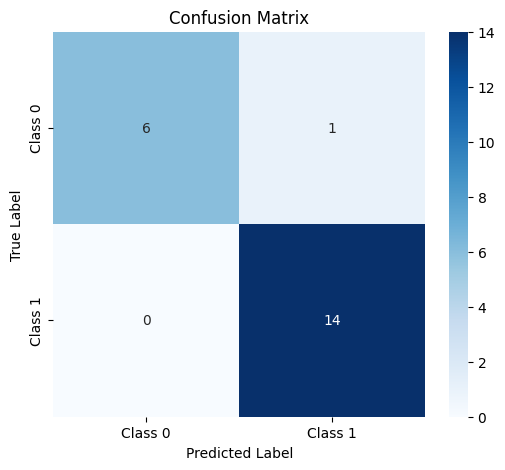

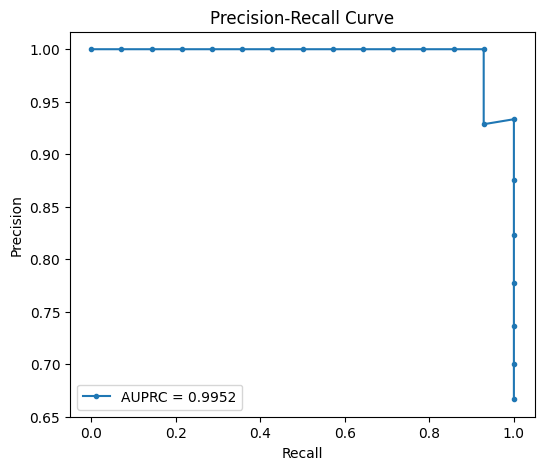

In [15]:
# evaluate the model
# Load the best model if it exists
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    precision_score, recall_score, f1_score, precision_recall_curve,
    average_precision_score
)

def evaluate(model):
    print(type(model))
    # model = load_model('best_model.h5')
    val_x = np.concatenate((validation_yes, validation_no))
    val_y = np.concatenate((np.ones(len(validation_yes)), np.zeros(len(validation_no))))
    
    # Get model predictions (probabilities)
    y_pred_probs = model.predict(val_x)
    PRED_THRESHOLD = 0.5
    y_pred = (y_pred_probs > PRED_THRESHOLD).astype(int)

    model.compile(loss='binary_crossentropy', metrics=['accuracy'])

    print("Confusion Matrix: ")
    cm = confusion_matrix(val_y, y_pred)
    
    print("Classification Report: ")
    report_dict = classification_report(val_y, y_pred, output_dict=True)
    df_report = pd.DataFrame(report_dict).T
    print(df_report)

    # Compute core metrics
    roc_auc = roc_auc_score(val_y, y_pred_probs)
    precision = precision_score(val_y, y_pred)
    recall = recall_score(val_y, y_pred)
    f1 = f1_score(val_y, y_pred)

    # Compute Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(val_y, y_pred_probs)
    auprc = average_precision_score(val_y, y_pred_probs)  # AUPRC (Area under PR curve)

    # Print metrics
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUPRC (Area Under Precision-Recall Curve): {auprc:.4f}")

    # Save classification report
    print(df_report)

    # Plot Confusion Matrix
    labels = ["Class 0", "Class 1"]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Plot Precision-Recall Curve
    plt.figure(figsize=(6, 5))
    plt.plot(recall_vals, precision_vals, marker='.', label=f'AUPRC = {auprc:.4f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()
# loads the best model and evaluates it
# model = load_model('best_model9523809552192688FT.h5')
evaluate(model)